# Fagaalu stream monitoring-Stream Stage and Rainfall
This Jupyter notebook will show how to process and analyze data from the ASEPA/SDSU Stream Monitoring program in Faga'alu Watershed, American Samoa

The overall objectives are to monitor in-stream suspended sediment yield (SSY) at three points in Faga'alu stream, particularly during storms. By comparing SSY up- and downstream of key sediment sources including the quarry, and the village, we can determine if sediment mitigation activities are successful.

SSY is being monitored at three points:
1 - FOREST - at the dam immediately upstream of the quarry
    Instrumentation:
    Solinst Barologger for barometric pressure data
    Solinst Levelogger for stream water level, aka "stage" (corrected using barometric pressure)
    CampbellSci OBS500 for turbidity
    
2 - QUARRY - immediately upstream of where the road crosses Faga'alu Stream near the quarry
    Instrumentation:
    CampbellSci OBS500 for turbidity
    Rainwise tipping bucket rain gauge with HOBO event logger
    
3 - LBJ - at a bridge behind LBJ hospital
    Instrumentation:
    Solinst Barologger for barometric pressure data
    Solinst Levelogger for stream water level, aka "stage" (corrected using barometric pressure)
    CampbellSci OBS500 for turbidity

The data is organized in folders corresponding to location, then instrument
Data is downloaded monthly by ASEPA staff and saved as .csv files for subsequent analysis

Let's go!


First, we'll import some modules

In [6]:
#### Import modules
## this determines if plots are static or interactive (inline for static pictures)
%matplotlib notebook 
## Data Processing
import os
import numpy as np
import pandas as pd
#import math
import datetime as dt
import matplotlib.pyplot as plt
## Set Pandas display options
pd.set_option('display.large_repr', 'truncate')
pd.set_option('display.width', 180)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
#pd.set_option('display.precision', 3)

#timer
import datetime as dt
now = dt.datetime.now()
print 'Start time: '+now.strftime('%H:%M:%S')
now_date = now.strftime('%d_%m_%Y')

Start time: 16:25:38


Next, let's set up our directories. This will be wherever you save your GitHub Repositories

In [7]:
#### DIRECTORIES
Laptop = 'Alex' ## you can use the presets below

if Laptop == 'Field': 
    maindir = "C:/Users/geoguser/Desktop/FieldLaptop/AmSamFieldLaptop/Siumu's Folder/"
    dirs={'main':maindir}
    
if Laptop == 'Alex': 
    maindir = "C:/Users/atm19/Documents/Github/Fagaalu_monitoring/Fagaalu_Monitoring_2016/"
    dirs={'main':maindir}
    
if Laptop == 'Trent': 
    maindir = "C:/Users/atm19/Google Drive/AmSamFieldLaptop/Siumu's Folder/" # <<<< TRENT ADD YOUR PATH HERE
    dirs={'main':maindir}

Define some start and end times :

In [11]:
## Year Interval Times 
start2016, stop2016 = dt.datetime(2016,1,1,0,0), dt.datetime(2016,6,1,11,59)   

Now we're going to import a function (another python script) that will import data from Solinst Barologgers and Leveloggers

In [12]:
from ExtraModules import Solinst_data_parser

So now we import barometric pressure data from Solinst Barologgers installed at FOREST and LBJ. These data will be used to correct the PT data to calculate water stage. 

This script will run through all the files downloaded by ASEPA staff, import any ending with '.csv', add an appropriate header, and make sure all data types are ready for analysis

In [13]:
## FOREST
Barologger_path = maindir+'1-FOREST/FOREST-Barologger/'
Barologger_raw_data  = pd.DataFrame()
for f in os.listdir(Barologger_path):
    if f.endswith('.csv') == True:
        print f
        raw = Solinst_data_parser(Barologger_path+f)
        raw = raw[['LEVEL','TEMPERATURE']]
        raw.columns  = ['Abs Pres, kPa','Temp, C']
        Barologger_raw_data = Barologger_raw_data.append(raw)
FOREST_Barologger_raw_data = Barologger_raw_data
FOREST_Barologger_raw_data['index']  = FOREST_Barologger_raw_data.index
FOREST_Barologger_raw_data = FOREST_Barologger_raw_data.drop_duplicates(cols='index')
FOREST_Barologger_raw_data = FOREST_Barologger_raw_data.reindex(pd.date_range(start2016,stop2016,freq='5Min'))

## LBJ
Barologger_path = maindir+'3-LBJ/LBJ-Barologger/'
Barologger_raw_data  = pd.DataFrame()
for f in os.listdir(Barologger_path):
    if f.endswith('.csv') == True:
        print f
        raw = Solinst_data_parser(Barologger_path+f)
        raw = raw[['LEVEL','TEMPERATURE']]
        raw.columns  = ['Abs Pres, kPa','Temp, C']
        Barologger_raw_data = Barologger_raw_data.append(raw)
LBJ_Barologger_raw_data= Barologger_raw_data
LBJ_Barologger_raw_data['index'] = LBJ_Barologger_raw_data.index
LBJ_Barologger_raw_data = LBJ_Barologger_raw_data.drop_duplicates(cols='index')
LBJ_Barologger_raw_data = LBJ_Barologger_raw_data.reindex(pd.date_range(start2016,stop2016,freq='5Min'))



FOREST-BL-03-02-2016.csv
FOREST-BL-04-12-2016.csv
FOREST-BL-05-04-2016.csv
LBJ-BL-03-02-2016.csv
LBJ-BL-05-04-2016.csv


Let's take a look at one file, just to see the structure

In [15]:
LBJ_Barologger_raw_data.dropna().head()

,"Abs Pres, kPa","Temp, C",index
2016-02-05 13:05:00,100.664,38.525,2016-02-05 13:05:00
2016-02-05 13:10:00,100.656,37.597,2016-02-05 13:10:00
2016-02-05 13:15:00,100.654,36.525,2016-02-05 13:15:00
2016-02-05 13:20:00,100.650,35.914,2016-02-05 13:20:00
2016-02-05 13:25:00,100.635,35.413,2016-02-05 13:25:00


Now we'll use the Barometric pressure data to correct the PT data, and calculate water stage.

In [16]:
### FOREST-PT
PT_path = maindir+'1-FOREST/FOREST-PT/'
FOREST_PT_raw_data = pd.DataFrame()
for f in os.listdir(PT_path):
    if f.endswith('.csv') == True:
        print f
        raw = Solinst_data_parser(PT_path+f)
        raw = raw[['LEVEL','TEMPERATURE']]
        raw.columns  = ['Abs Pres, kPa','Temp, C']
        FOREST_PT_raw_data = FOREST_PT_raw_data.append(raw)
## CLEAN UP DATA       
FOREST_PT_raw_data = FOREST_PT_raw_data.sort_index()
FOREST_PT_raw_data['index'] = FOREST_PT_raw_data.index
FOREST_PT_raw_data = FOREST_PT_raw_data.drop_duplicates(cols = 'index')
## BAROMETRIC COMPENSATION
FOREST_PT_raw_data['Baropress'] = FOREST_Barologger_raw_data['Abs Pres, kPa']
FOREST_PT_raw_data['Pressure_compensated'] = FOREST_PT_raw_data['Abs Pres, kPa']-FOREST_PT_raw_data['Baropress']
FOREST_PT_raw_data['stage cm'] = FOREST_PT_raw_data['Pressure_compensated']*0.102*100.0
FOREST_PT_raw_data = FOREST_PT_raw_data.reindex(pd.date_range(start2016,stop2016,freq='5Min'))
## Save for later
FOREST_PT_raw_data.to_csv(maindir+'1-FOREST/FOREST-PT-Stage-'+now_date+'.csv')

### LBJ-PT
PT_path = maindir+'3-LBJ/LBJ-PT/'
LBJ_PT_raw_data = pd.DataFrame()
for f in os.listdir(PT_path):
    if f.endswith('cm.csv') == True:
        print f
        raw = Solinst_data_parser(PT_path+f)
        raw = raw[['LEVEL','TEMPERATURE']]
        raw.columns  = ['Abs Pres, kPa','Temp, C']
        LBJ_PT_raw_data = LBJ_PT_raw_data.append(raw)
## CLEAN UP DATA          
LBJ_PT_raw_data = LBJ_PT_raw_data.sort_index()
LBJ_PT_raw_data['index'] = LBJ_PT_raw_data.index
LBJ_PT_raw_data = LBJ_PT_raw_data.drop_duplicates(cols = 'index')
## The PT at LBJ was launched with units "cm water", and we want to conver to kilopascals to correspond to barometric data
LBJ_PT_raw_data ['Abs Pres, kPa'] = LBJ_PT_raw_data ['Abs Pres, kPa']*0.0980665
## BAROMETRIC COMPENSATION
LBJ_PT_raw_data['Baropress'] = LBJ_Barologger_raw_data['Abs Pres, kPa']
LBJ_PT_raw_data['Pressure_compensated'] = LBJ_PT_raw_data['Abs Pres, kPa']-LBJ_PT_raw_data['Baropress']
LBJ_PT_raw_data['stage cm'] = LBJ_PT_raw_data['Pressure_compensated']*0.102*100.0
LBJ_PT_raw_data = LBJ_PT_raw_data.reindex(pd.date_range(start2016,stop2016,freq='5Min'))

## Save for later
LBJ_PT_raw_data.to_csv(maindir+'3-LBJ/LBJ-PT-Stage-'+now_date+'.csv')


FOREST-PT-03-02-2016.csv
FOREST-PT-05-04-2016.csv
LBJ-PT-05-04-2016_cm.csv


Let's have a look


In [17]:
LBJ_PT_raw_data.dropna().head()

,"Abs Pres, kPa","Temp, C",index,Baropress,Pressure_compensated,stage cm
2016-02-05 13:05:00,100.763329,37.3,2016-02-05 13:05:00,100.664,0.099329,1.013153
2016-02-05 13:10:00,101.185015,31.2,2016-02-05 13:10:00,100.656,0.529015,5.395950
2016-02-05 13:15:00,101.145788,30.8,2016-02-05 13:15:00,100.654,0.491788,5.016239
2016-02-05 13:20:00,101.135981,30.6,2016-02-05 13:20:00,100.650,0.485981,4.957011
2016-02-05 13:25:00,101.116368,30.4,2016-02-05 13:25:00,100.635,0.481368,4.909955


Now we'll add data from the rain gauge at the QUARRY. This helps when looking at the PT data, to see if rainfall and water level rise occur together.

Rain gauge data is not recorded at regular intervals, since it is event-based in nature. The datalogger records when the bucket is tipped, and these tips then need to be resampled to calculate total rainfall within a given time interval.


In [21]:
## QUARRY Rain Gauge
## IMPORT DATA
QUARRY_RG_path = maindir+'2-QUARRY/QUARRY-RAIN GAUGE/'
QUARRY_RG_raw_data = pd.DataFrame()
for f in os.listdir(QUARRY_RG_path):
    if f.endswith('.csv') == True:
        print f
        raw = pd.DataFrame.from_csv(QUARRY_RG_path+f,header=1,parse_dates=1,index_col=1)
        raw = raw.ix[:,1:3]
        raw.columns  = ['Temp, C','Events']
        QUARRY_RG_raw_data = QUARRY_RG_raw_data.append(raw)
## CLEAN UP DATA       
QUARRY_RG_raw_data = QUARRY_RG_raw_data.sort_index()
QUARRY_RG_raw_data['index'] = QUARRY_RG_raw_data.index
QUARRY_RG = QUARRY_RG_raw_data.drop_duplicates(cols = 'index')
## Resample cumulative events to 1 minute (eg. 16:00 to 16:01 has two events at 16:00:15 and 16:00:44 so 16:00=2; next event is at 16:02:13 so 16:01=2 and 16:02=3)
QUARRY_RG_1Min=pd.DataFrame()
QUARRY_RG_1Min['Events_Cum_1Min'] = QUARRY_RG['Events'].resample('1Min',how='last',fill_method='ffill')
QUARRY_RG_1Min['Events_Cum_15Min'] = QUARRY_RG['Events'].resample('15Min',how='last',fill_method='ffill')
## Subtract previous minutes events from the following minute (eg. cumulative events at 16:00=2, and at 16:02=3 so events for 16:02=1) 
QUARRY_RG_1Min['Events_1Min'] = QUARRY_RG_1Min['Events_Cum_1Min'] - QUARRY_RG_1Min['Events_Cum_1Min'] .shift(1).fillna(0) ## fillna(0) is for the very first value, it would be NaN when shifted down
QUARRY_RG_1Min['Events_15Min'] = QUARRY_RG_1Min['Events_Cum_15Min'].dropna() - QUARRY_RG_1Min['Events_Cum_15Min'].dropna().shift(1).fillna(0) ## fillna(0) is for the very first value, it would be NaN when shifted down
## Events to mm
QUARRY_RG_1Min['mm_1Min'] = QUARRY_RG_1Min['Events_1Min']*0.254 ##hundredths to mm
QUARRY_RG_1Min['mm_15Min'] = QUARRY_RG_1Min['Events_15Min']*0.254 ##hundredths to mm
## Reindex into a 15Min interval
QUARRY_RG = QUARRY_RG_1Min[['mm_15Min']].reindex(pd.date_range(start2016,stop2016,freq='15Min'))

## save for later
QUARRY_RG.to_csv(maindir+'2-QUARRY/QUARRY-RAIN GAUGE/Precip_15Min'+now_date+'.csv')

QUARRY-RAING_GAUGE-02-04-2016.csv
QUARRY-RAIN_GAUGE-02-03-2016.csv
QUARRY-RAIN_GAUGE-03-02-2016.csv
QUARRY-RAIN_GAUGE-04-12-2016.csv
QUARRY-RAIN_GAUGE-05-04-2016.csv


In [22]:
QUARRY_RG.head()

,mm_15Min
2016-01-01 00:00:00,0
2016-01-01 00:15:00,0
2016-01-01 00:30:00,0
2016-01-01 00:45:00,0
2016-01-01 01:00:00,0


So at this point we have rainfall and hydrograph (stream level) data

We'll want to look at the stream stage data to see if there are any baselevel shifts or delete bad data

So let's plot the rainfall and stream stage data to see what we have!


<IPython.core.display.Javascript object>


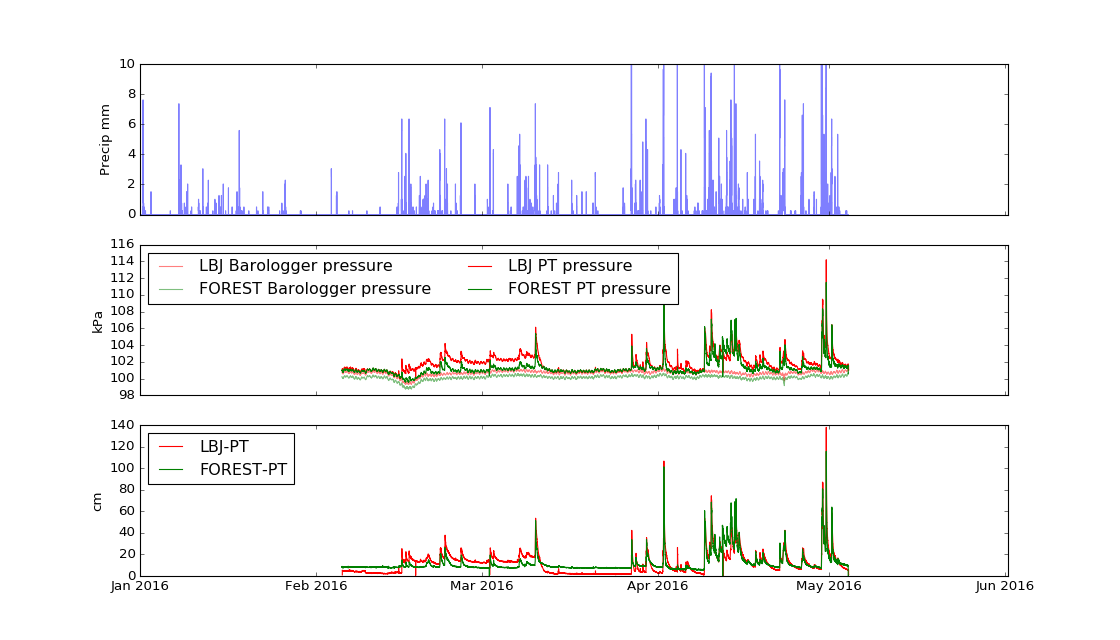

(735964.0, 736116.4993055556)

In [23]:
### PLOTTING RAW DATA

fig, (precip, pressure, stage) = plt.subplots(3,1,figsize=(14,8),sharex=True) 

## PRECIP
precip.plot_date(QUARRY_RG.index, QUARRY_RG['mm_15Min'], color='b',alpha=0.5,ls='steps-pre', marker='None',label='Precip_mm_15Min')
precip.set_ylabel('Precip mm'), precip.set_ylim(0,10)
plt.show() 

### BAROMETRIC and TRANSDUCER PRESSURE

## BAROMETERS
## LBJ-BL-Barologger at LBJ
pressure.plot_date(LBJ_Barologger_raw_data.index, LBJ_Barologger_raw_data['Abs Pres, kPa'],alpha=0.5, ls='-', marker='None', label='LBJ Barologger pressure', color='r')
## FOREST-BL-Barologger at FOREST
pressure.plot_date(FOREST_Barologger_raw_data.index, FOREST_Barologger_raw_data['Abs Pres, kPa'],alpha=0.5, ls='-', marker='None', label='FOREST Barologger pressure', color='g')


## PTs
## LBJ-PT
pressure.plot_date(LBJ_PT_raw_data['Abs Pres, kPa'].index, LBJ_PT_raw_data['Abs Pres, kPa'], ls='-', marker='None', label='LBJ PT pressure',color='r')
## FOREST-PT
pressure.plot_date(FOREST_PT_raw_data['Abs Pres, kPa'].index, FOREST_PT_raw_data['Abs Pres, kPa'], ls='-', marker='None', label='FOREST PT pressure',color='g')
## fmt
pressure.legend(loc='upper left', ncol=2)
pressure.set_ylabel('kPa')
pressure.set_xlim(start2016,stop2016)


### STAGE
## LBJ-PT
stage.plot_date(LBJ_PT_raw_data['stage cm'].index, LBJ_PT_raw_data['stage cm'], ls='-', marker='None', label='LBJ-PT',color='r')
## FOREST-PT
stage.plot_date(FOREST_PT_raw_data['stage cm'].index, FOREST_PT_raw_data['stage cm'], ls='-', marker='None', label='FOREST-PT',color='g')
## fmt
stage.legend(loc='upper left')
stage.set_ylabel('cm')
stage.set_xlim(start2016,stop2016)
